<a href="https://colab.research.google.com/github/yaswanth19/RNA-Scope-Image-Analysis/blob/main/RNA_Analysis_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#General Libraries

import numpy as np
import os
import gc
import random

#Image Processing
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import filters, feature, measure,transform,draw,color, io
Image.MAX_IMAGE_PIXELS=None

# Dividing into Patches

In [ ]:
path='/content/drive/MyDrive/CMU/Copy of frame_t_0_MaxP.ome.tif'
tif_img=Image.open(path)
image_arr=np.array(tif_img)

In [ ]:
#Code to extract a patch from tif file
height, width = image_arr.shape[:2]
patch_size = (height // 8, width // 8)

# Create a list to hold the patches
patches = []

# Divide the image into patches and append them to the list
for i in range(8):
    for j in range(8):
        patch = image_arr[i * patch_size[0]:(i + 1) * patch_size[0], j * patch_size[1]:(j + 1) * patch_size[1]]
        patches.append(patch)

# Print the number of patches and the size of each patch
print(f"Divided image into {len(patches)} patches of size {patch_size}.")


Divided image into 64 patches of size (2486, 1616).


In [ ]:
del patch
gc.collect()

42

In [ ]:
for i in range(len(patches)):
  img_arr=patches[i] 
  plt.imsave(f"/content/Patch{i+1}.png",img_arr)

# Processing The Patch

In [ ]:
path='/content/drive/MyDrive/CMU/Patches/Patch10.png'
img=Image.open(path)
mag_factor = 12
resized_img = img.resize((int(img.size[0]*mag_factor), int(img.size[1]*mag_factor)))
resized_arr= np.array(resized_img)

In [ ]:
# Doing basic thresholding and other processing to get a better image
lower = np.array([0, 0, 0])
upper = np.array([100, 255, 255])

# image to the HSV color space
hsv = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2HSV)

#thresholding the image in the HSV color space
mask = cv2.inRange(hsv, lower, upper)

# Apply bitwise-and to the original image and the mask to extract the particles
img_array = cv2.bitwise_and(resized_arr,resized_arr, mask=mask)

In [ ]:
del resized_arr,resized_img,hsv,mask
gc.collect()

8

In [ ]:
rgb_image=cv2.cvtColor(img_array, cv2.COLOR_BGRA2BGR)
# plt.imshow(rgb_image)
copy_img=rgb_image

In [ ]:
del img_array
gc.collect()

0

In [ ]:
gray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

#Adaptive thresholding to segment the image
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#Morphological operations to clean up the image
kernel = np.ones((2,2), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)


In [ ]:
contours, _ = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
len(contours)

7299

# Experimentation

In [ ]:
!pwd

/content


In [ ]:
circular_contours=[]
for contour in contours:
    if len(contour) < 5:
        continue

    area = cv2.contourArea(contour)
    hull_area = cv2.contourArea(cv2.convexHull(contour))
    circularity = area / float(hull_area)
    
    if circularity < 0.95: 
        continue

    if area < 250:
      continue

    if not cv2.isContourConvex(contour):
        contour = cv2.convexHull(contour)
        circular_contours.append(contour)

len(circular_contours)

3273

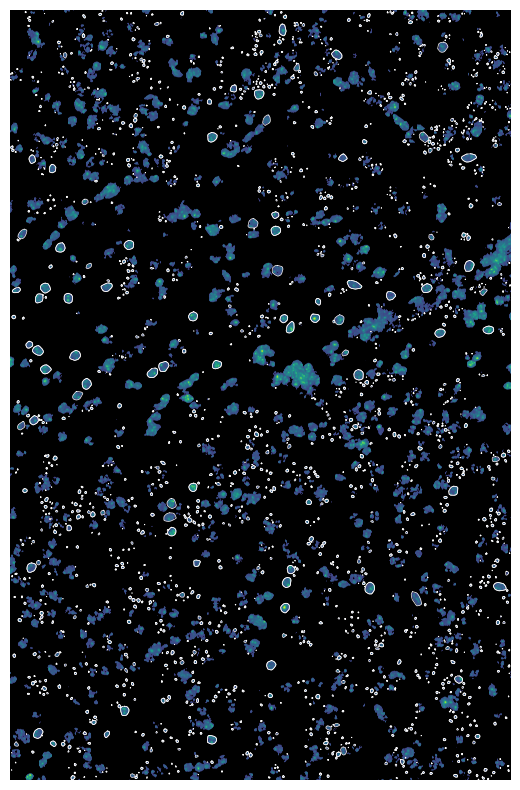

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow((rgb_image))
for contour in circular_contours:
  ax.plot(contour[:,:,0], contour[:,:,1], linewidth=0.5, color='white')
plt.axis('off')  
plt.show()

In [ ]:
# some_cont=[]
# for contour in contours:
#   mu = cv2.moments(contour)
#   major_axis_length = 2 * np.sqrt(mu['mu20'] + mu['mu02'] + np.sqrt((mu['mu20'] - mu['mu02'])**2 + 4*mu['mu11']**2))
#   minor_axis_length = 2 * np.sqrt(mu['mu20'] + mu['mu02'] - np.sqrt((mu['mu20'] - mu['mu02'])**2 + 4*mu['mu11']**2))
#   eccentricity = np.sqrt(1 - (minor_axis_length/major_axis_length)**2)
#   if 0.3 < eccentricity< 0.6:
#     some_cont.append(contour)


In [ ]:
# filtered_contours=[]
# for contour in contours:
#     if len(contour) < 5:
#       continue

#     if not cv2.isContourConvex(contour):
#         contour = cv2.convexHull(contour)
          
#     if len(contour) >= 5:
#         (x, y), (ma,MA), angle = cv2.fitEllipse(contour)
#         eccentricity1 = np.sqrt(1 - (abs(ma / MA))**2)
#         if 0.3 < eccentricity1 < 0.6:
#             filtered_contours.append(contour)


In [ ]:
del closing,opening
gc.collect()

0

In [ ]:
def calculate_black_percentage(image):
  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


    black_pixels = np.sum(binary == 0)
    total_pixels = binary.size
    black_percentage = (black_pixels / total_pixels) * 100

    cv2.drawContours(image, contours, -1, (0, 255, 0), 1)

    return 100-black_percentage, image

# Continue

In [ ]:
%cd /content/drive/MyDrive/RNA Analysis

[Errno 2] No such file or directory: '/content/drive/MyDrive/RNA Analysis'
/content


In [ ]:
!ls

drive  sample_data


In [ ]:
if not os.path.exists('pparticles/'):
  os.mkdir('pparticles/')

In [ ]:
print(len(circular_contours))

4346


In [ ]:
MIN_AREA=300
MARGIN=1 #5PIXELS

for i, contour in enumerate(circular_contours):
    (x,y,w,h) = cv2.boundingRect(contour)
    x -= MARGIN # add margin to the left
    y -= MARGIN # add margin to the top
    w += 2*MARGIN # add margin to both sides
    h += 2*MARGIN # add margin to both top and bottom
    area = w * h

    if area >= MIN_AREA:
      if x >= 0 and y >= 0 and x+w <= copy_img.shape[1] and y+h <= copy_img.shape[0]:
              roi = copy_img[y:y+h, x:x+w]
              cv2.imwrite('pparticles/particle{}.jpg'.format(i), roi)

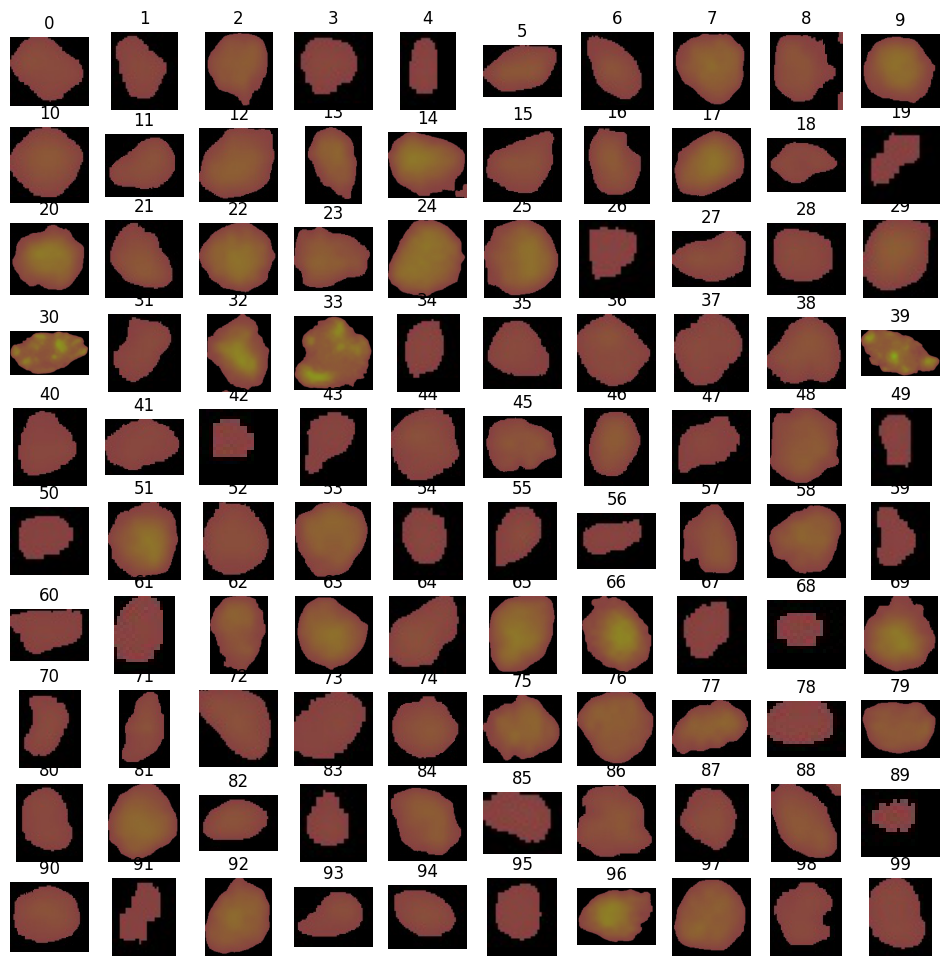

In [ ]:
random.seed(408)
lst = os.listdir('/content/pparticles/')
random_files = random.sample(lst, 100)
fig, axs = plt.subplots(10, 10, figsize=(12, 12))

for i, file_name in enumerate(random_files):
    # Open the image file
    image = Image.open(os.path.join('/content/pparticles/', file_name))
    image_array = np.array(image)
    row = i // 10
    col = i % 10
    axs[row, col].imshow(image_array)
    axs[row, col].axis('off')
    axs[row, col].set_title(str(i))
  
plt.show()


In [ ]:
indices

[(3, 60.57142857142857),
 (4, 69.36274509803921),
 (19, 74.81789802289282),
 (26, 67.47126436781609),
 (34, 64.92969396195203),
 (42, 77.4703557312253),
 (43, 62.0958751393534),
 (49, 72.02898550724638),
 (50, 64.76190476190476),
 (54, 63.72549019607843),
 (55, 63.142857142857146),
 (56, 65.98440545808967),
 (59, 64.01414677276746),
 (67, 64.33179723502303),
 (68, 76.19047619047619),
 (70, 60.20531400966183),
 (83, 67.64705882352942),
 (89, 80.14354066985646),
 (91, 67.84922394678492),
 (95, 62.41319444444444)]

In [ ]:
import cv2
import numpy as np

def calculate_eccentricity(contour):
    # Fit an ellipse to the contour
    (x, y), (width, height), angle = cv2.fitEllipse(contour)

    # Calculate major and minor axes lengths
    major_axis = max(width, height)
    minor_axis = min(width, height)

    # Calculate eccentricity
    eccentricity = np.sqrt(1 - (minor_axis ** 2) / (major_axis ** 2))

    return eccentricity

def detect_and_calculate_eccentricity(image_dir):
  for i,val in enumerate(image_dir):
    image=plt.imread(os.path.join('/content/particles',val)) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    eccentricities = []
    for contour in contours:
        eccentricity = calculate_eccentricity(contour)
        eccentricities.append((i,eccentricity))

    return eccentricities

eccentricities = detect_and_calculate_eccentricity(random_files)


In [ ]:
def calculate_black_percentage(image):
  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


    black_pixels = np.sum(binary == 0)
    total_pixels = binary.size
    black_percentage = (black_pixels / total_pixels) * 100

    cv2.drawContours(image, contours, -1, (0, 255, 0), 1)

    return 100-black_percentage, image

indices=[]

for i,filename in enumerate(random_files):
  image=plt.imread(os.path.join('/content/pparticles/',filename))
  black_percentage, image_with_contours = calculate_black_percentage(image)

  if black_percentage > 60:
    indices.append((i,black_percentage))

In [ ]:
lst = os.listdir('/content/particles/')
selected_images = []

for file_name in random.sample(lst, 100):
 
    image = Image.open(os.path.join('/content/particles/', file_name))
    image_array = np.array(image)
    
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
  
    black_pixels_percentage = np.mean(gray_image == 0) * 100
    if black_pixels_percentage > 40:  
        selected_images.append(image_array)


fig, axs = plt.subplots(10, 10, figsize=(12, 12))

for i, image_array in enumerate(selected_images):
    row = i // 10
    col = i % 10
    axs[row, col].imshow(image_array)
    axs[row, col].axis('off')

plt.show()


In [ ]:
# Drawing a BBox and saving that region
for i, contour in enumerate(contours):
    (x,y,w,h) = cv2.boundingRect(contour)
    cv2.rectangle(copy_img, (x, y), (x + w, y + h), (0, 255, 0), 2) # Draw bounding box on the RGB image
    roi = copy_img[y:y+h, x:x+w] # Crop the region of interest
    #cv2.imwrite('Images/particle{}.jpg'.format(i), roi) # Save the cropped particle image

cv2.imwrite('Images/detected_particles.jpg', rgb_image) # Save the RGB image with bounding boxes

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread('/content/Images/detected_particles.jpg'))

In [ ]:
lst=os.listdir('/content/Images/')
random_files = random.sample(lst, 10)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, file_name in enumerate(random_files):
    # Open the image file
    image = Image.open(os.path.join('/content/Images/', file_name))
    image_array = np.array(image)
    row = i // 5
    col = i % 5
    axs[row, col].imshow(image_array)
    axs[row, col].axis('off')

plt.show()